# Exam

Develop a model for predicting review rating.  
**Binary classification:**  
**positive class: target = 5**   
**negative class: target = 1,2,3,4**  
Score: **binary F1**  
You are forbidden to use test dataset for any kind of training.  
Remember proper training pipeline.  
If you are not using default params in the models, you have to use some validation scheme to justify them. 

Use `random_state` or `seed` params - your experiment must be reprodusible.


### 1 baseline = 0.720
### 2 baseline = 0.745


4. Compare logistic regression and SVM: decision surface and robustness

LogisticRegression строит поверхность таким образом, чтобы область 0х меток была как можно меньше, в отличие от SVM, который строит разделяющюю плоскость таким образом, чтобы она отделяла классы с наибольшим запасом.

Vanilla SVM плохо устойчив к выбросам, так как сам метод нуждается в сильном предположении о разделимости классов. LogisticRegression, как и любая модель, базирующаяся на линейности, работает лучше при большей разделимости классов, в целом остро реагирует на выбросы.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from collections import Counter
from tqdm import tqdm as tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir exam_data/
!cp drive/My\ Drive/exam/exam_data/train.csv exam_data/
!cp drive/My\ Drive/exam/exam_data/test.csv exam_data/

In [0]:
df_train = pd.read_csv('exam_data/train.csv')
df_test = pd.read_csv('exam_data/test.csv')

df_train['target'] = (df_train['target'] == 5).astype(np.int)
df_test['target'] = (df_test['target'] == 5).astype(np.int)

In [3]:
df_train.head()

,review,title,target
0,"The staff was very friendly, the breakfast ver...",Walker Gem,1
1,Excellent service - very approachable and prof...,Excellent Service,0
2,Really a top notch place to spend a day at the...,"Good location, warm and friendly staff",1
3,"a little noisy, there was a false fire alarm a...","nice hotel,",0
4,Place had too many animals and I'm allergic to...,Experience,0


### Preprocessing

In [0]:
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
df_train['clean_review'] = df_train['review'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
df_train['clean_review'] = df_train['clean_review'].str.lower()
df_train['clean_review'] = df_train['clean_review'].apply(lambda x:' '.join(x.split()))

df_test['clean_review'] = df_test['review'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
df_test['clean_review'] = df_test['clean_review'].str.lower()
df_test['clean_review'] = df_test['clean_review'].apply(lambda x:' '.join(x.split()))


In [0]:
text_columns = ["title", "clean_review"]
target_column = "target"


In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
# see task above
def normalize(text):
    text = str(text).lower()
    return ' '.join(tokenizer.tokenize(text))
    
df_train[text_columns] = df_train[text_columns].applymap(normalize)
df_test[text_columns] = df_test[text_columns].applymap(normalize)


token_counts = Counter()

for _, row in tqdm(df_train[text_columns].iterrows()):
    for string in row:
        token_counts.update(string.split())

48192it [00:05, 9629.58it/s]


In [8]:
min_count = 5

tokens = [token for token, count in token_counts.items() if count >= min_count]

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 12578


In [0]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [11]:
print("Lines:")
print('\n'.join(df_train["clean_review"][::30000].values), end='\n\n')
print("Matrix:")
print(as_matrix(df_train["clean_review"][::30000]))

Lines:
the staff was very friendly , the breakfast very nice . extremely comfortable beds .
this hotel is in a great locations and was excellent for the price . right next to the gallaria . doug , were glad you stayed at our location while attending an event at the cobb galleria center . while price is important to the hotel success we understand our customer is the reason we are in business . please feel free to stay with our wingate brand locations in the near future . willis blake dos

Matrix:
[[11152 10548 12145 11955  4816    27 11152  1809 11955  7575    37  4343
   2607  1461    37     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1]
 [11194  5616  6055  

In [0]:
def make_batch(data, max_len=None, word_dropout=0):

    batch = {}
    batch["title"] = as_matrix(data["title"].values, max_len)
    batch["review"] = as_matrix(data["clean_review"].values, max_len)
    
    if word_dropout != 0:
        batch["review"] = apply_word_dropout(batch["review"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [0]:
b_0 = make_batch(df_train[:3], max_len=10)

In [0]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [0]:
from sklearn.metrics import f1_score

In [0]:
import torch
from torch import nn
import torch.nn.functional as F

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
class TwoInputsNet(nn.Module):
    def __init__(self, n_tokens, concat_number_of_features, hid_size=64):
        super(TwoInputsNet, self).__init__()
        self.title_emb = nn.Embedding(n_tokens, embedding_dim=hid_size)
        self.title_conv = nn.Conv1d(hid_size, hid_size, padding=1, kernel_size=3)
        self.title_pool = nn.AdaptiveMaxPool1d(5)

        self.full_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        self.full_conv = nn.Conv1d(hid_size, hid_size, kernel_size=7, padding=3)
        self.full_pool = nn.AdaptiveMaxPool1d(hid_size)
        self.full_conv2 = nn.Conv1d(hid_size, hid_size*2, kernel_size=5, padding=2)
        self.full_pool2 = nn.AdaptiveMaxPool1d(8)
        
        self.inter_dense = nn.Linear(in_features=concat_number_of_features, out_features=hid_size*2)
        self.bn1 = nn.BatchNorm1d(num_features=hid_size*2)
        self.final_dense = nn.Linear(in_features=hid_size*2, out_features=1)

        self.forw = nn.Sigmoid()

    def forward(self, whole_input):
        input1, input2 = whole_input
        title_beg = self.title_emb(input1).permute((0, 2, 1))
        title = self.title_pool(self.title_conv(title_beg))

        full_beg = self.full_emb(input2).permute((0, 2, 1))
        full = self.full_pool(self.full_conv(full_beg))
        full = self.full_pool2(self.full_conv2(full))

        concatenated = torch.cat(
            [
            title.view(title.size(0), -1),
            full.view(full.size(0), -1),
            ],
            dim=1)
        
        out = self.final_dense(F.relu(self.inter_dense(concatenated)))
        out = self.forw(out)
        return out

In [0]:
np.random.seed(0)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [136]:
model = TwoInputsNet(
    n_tokens=len(tokens),
    
    # title: max_len*hid_size/2 = 5*64
    # review: 128 * 8
    # sum is 1024 + 320
    
    concat_number_of_features=1344
)

def init_weights(m):
    
    for name, p in m.named_parameters():
        if p.dim() > 1:
          nn.init.xavier_uniform(p.data)
        
model.apply(init_weights);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


In [0]:
model.to(device);

torch.cuda.empty_cache()

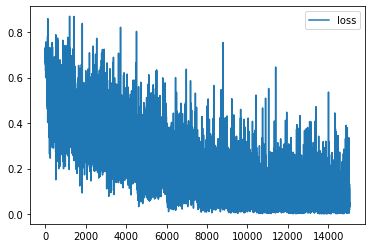

In [138]:
from IPython.display import clear_output
from random import sample

batch_size = 32

opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCELoss().to(device)

history = []
epochs = 10

for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(df_train, batch_size)):
        
        to_model = [
                    torch.tensor(batch['title'], dtype=torch.long).to(device),
                    torch.tensor(batch['review'], dtype=torch.long).to(device)
                    ]
        
        target = torch.tensor(target, dtype=torch.float).view(-1, 1).to(device)
        predictions = model(to_model)
        loss = loss_func(predictions, target)

        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.cpu().data.numpy())
        if (idx+1)%100==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()

In [0]:
model.eval()

for idx, (batch, target) in enumerate(iterate_minibatches(df_test, len(df_test))):
    to_model = [
                    torch.tensor(batch['title'], dtype=torch.long).to(device),
                    torch.tensor(batch['review'], dtype=torch.long).to(device)
                    ]
        
    target = torch.tensor(target, dtype=torch.float).view(-1, 1)
    predictions = model(to_model)

In [0]:
y_true = target.detach().numpy()

In [0]:
y = predictions.cpu().detach().numpy()
p_tresh = 0.1 # выбираем малое значение, так как логит обособляет сужает область принятия 0й метки

y[y >= p_tresh] = 1
y[y < p_tresh] = 0

In [148]:
f1_score(y_true, y)

0.7215587680703961